In [1]:
__authors__ = "Akshay Agarwal, Manish Das, Jaro Habr, Parag Kanade"
__version__ = "XCS229ii, Stanford, Spring 2021"

# Experiments: Model based on U-Net - Trained on Azure

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

if 'notebooks' in os.getcwd():
    os.chdir("..")

print(os.getcwd())

/Users/jh/ai/courses/stanford/3-ML_RL/final_project/xcs229ii_final_project/code


### Helper methods

## Load Model Weights From Azure Instance

### Experiment 10 - VGG, ImageNet Weights, 128x128

Experiments based on [experiment list](https://docs.google.com/spreadsheets/d/1bsp8puoiK3ay0rUYdjFXcbxXf6iSJZenIWtoiWczlBA/edit#gid=1999600204https://docs.google.com/spreadsheets/d/1bsp8puoiK3ay0rUYdjFXcbxXf6iSJZenIWtoiWczlBA/edit#gid=1999600204).

Segmentation Models: using `tf.keras` framework.


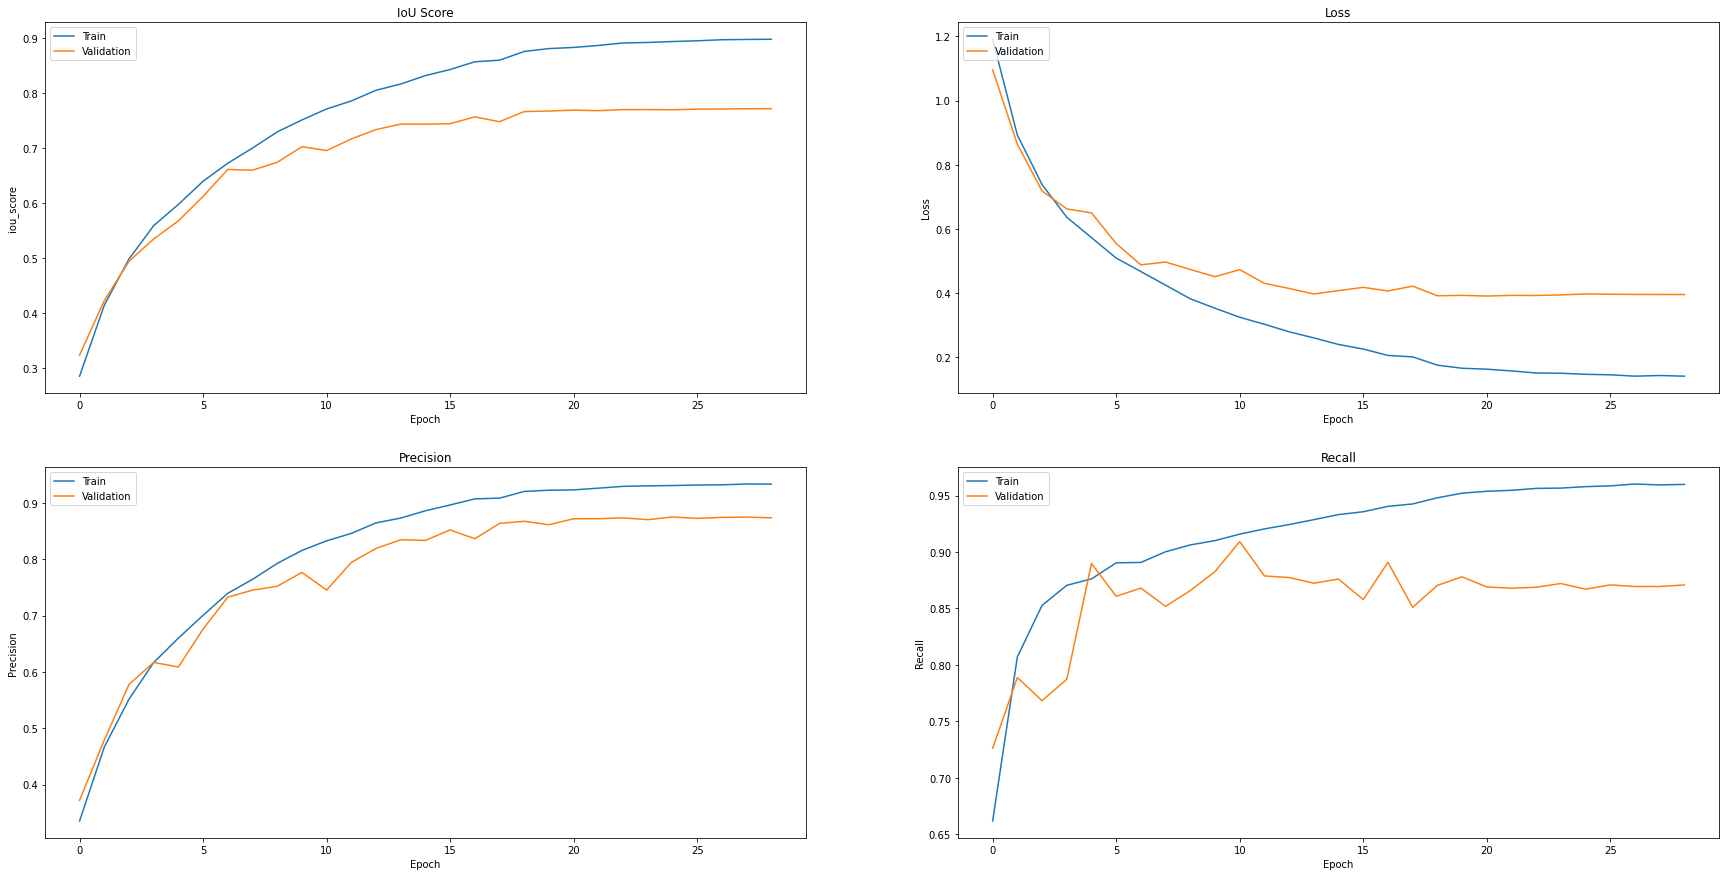

In [4]:
from utils.helper import Visualisation
import pickle
import os
from constants import EXPORT_DIR

AZURE_PATH = os.path.join(EXPORT_DIR, "azure", "2021_05_17_2340", "unet")

azure_hitory_path = os.path.join(AZURE_PATH, "unet_10_train_history.pkl")
azure_history = pickle.load(open(azure_hitory_path, "rb"))
Visualisation().plot_curves(azure_history)

#### Test Images (Unseen)

In [5]:
import segmentation_models as sm

azure_model = sm.Unet(encoder_weights='imagenet', activation='sigmoid')
azure_model.load_weights(os.path.join(AZURE_PATH, "unet_10_weights_only.h5"))

In [6]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128), size=5)

Image shape: (1, 128, 128, 3)
Predicted mask shape: (1, 128, 128, 1)
Mask shape: (128, 128, 1)


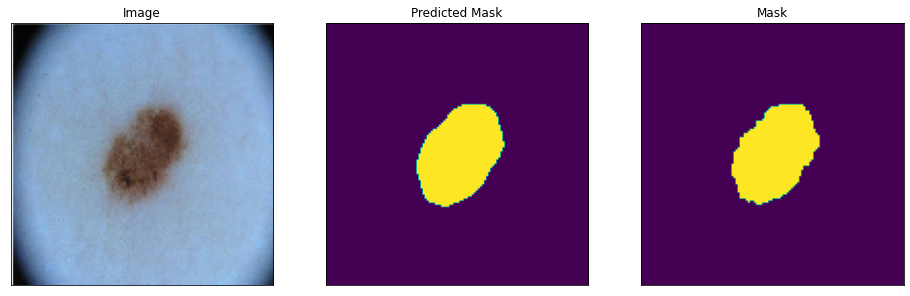

Image shape: (1, 128, 128, 3)
Predicted mask shape: (1, 128, 128, 1)
Mask shape: (128, 128, 1)


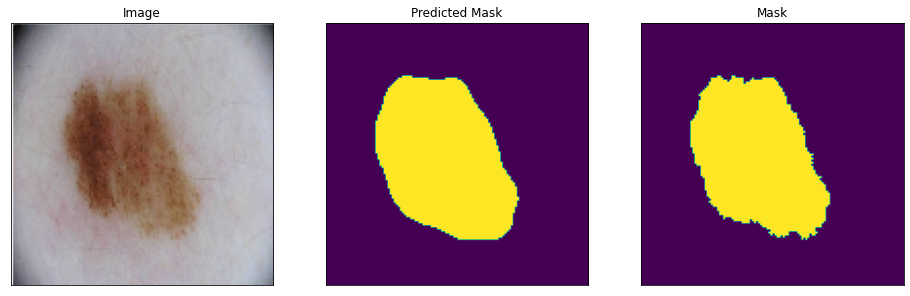

Image shape: (1, 128, 128, 3)
Predicted mask shape: (1, 128, 128, 1)
Mask shape: (128, 128, 1)


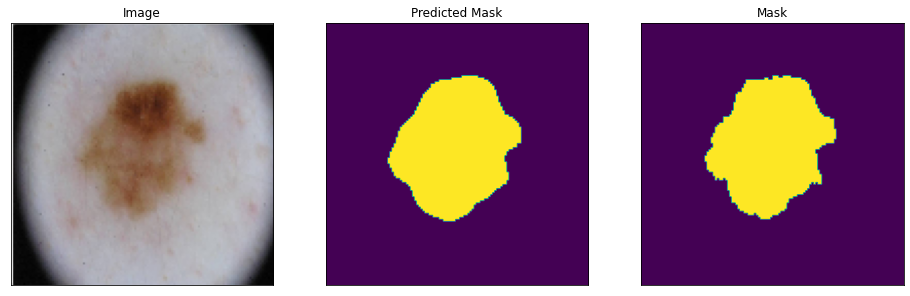

Image shape: (1, 128, 128, 3)
Predicted mask shape: (1, 128, 128, 1)
Mask shape: (128, 128, 1)


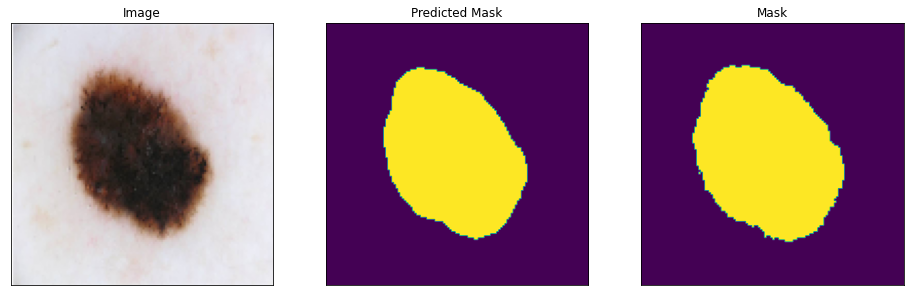

Image shape: (1, 128, 128, 3)
Predicted mask shape: (1, 128, 128, 1)
Mask shape: (128, 128, 1)


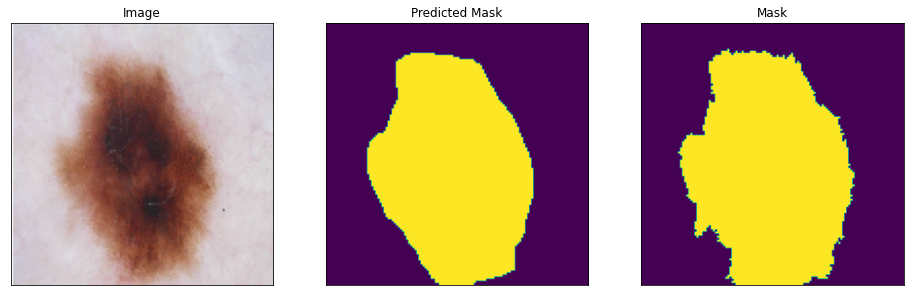

In [7]:
NotebookHelper().plot_images_masks(azure_model, test_images, test_masks)

### Calculate Metrics

This metric calculation is based on the [umetrics library](https://github.com/quantumjot/unet_segmentation_metrics).

The calculation uses the jaccard index threshold from the dataset description [landing page](https://challenge2018.isic-archive.com/task1/), section `metrics`, which is `0.65`.

In [8]:
%%time

from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128))
print(len(test_images))

300
CPU times: user 1min 21s, sys: 4.2 s, total: 1min 25s
Wall time: 1min 27s


In [9]:
%%time

import numpy as np

predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    predicted_mask = azure_model.predict(test_image).round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

assert predicted_masks.shape == (len(test_masks), 128, 128, 1)

CPU times: user 1min 55s, sys: 13.8 s, total: 2min 9s
Wall time: 32.4 s


In [10]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

CPU times: user 14.9 s, sys: 169 ms, total: 15 s
Wall time: 15.4 s


{'n_images': 300,
 'n_true_positives': 1021645,
 'n_true_positives_%': 0.8989452640711382,
 'n_true_negatives': 3687472,
 'n_true_negatives_%': 0.9758554976609723,
 'n_false_positives': 91235,
 'n_false_negatives': 114848,
 'iou_score': 0.8219148897497744,
 'threshold_jaccard_index': 0.7649807612619688,
 'jaccard_similarity_index': 0.8219148897497744,
 'dice': 0.8917741889592693,
 'f1_score': 0.44588709447963465,
 'sensitivity': 0.9103553094606324,
 'specificity': 0.9713861015548235,
 'accuracy': 0.9580723063151042}

#### Full Image Resolution Metrics

In [11]:
%%time

from constants import TEST_DIR
from utils.helper import NotebookHelper

full_size_test_images, full_size_test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, normalize=False)
print(len(full_size_test_images))

300
CPU times: user 2min 2s, sys: 9.31 s, total: 2min 11s
Wall time: 2min 12s


In [12]:
%%time

import cv2
import numpy as np

full_size_predicted_masks = []

for index, full_size_test_image in enumerate(full_size_test_images):
        height, width = full_size_test_images[index].shape[:-1]
        # scale up predicted mask to original image resolution
        full_size_predicted_mask = cv2.resize(
            src=predicted_masks[index],
            dsize=(width, height),
            interpolation=cv2.INTER_NEAREST
        )
        full_size_predicted_mask = np.expand_dims(full_size_predicted_mask, axis=2)
        
        assert full_size_predicted_mask.shape[:-1] == full_size_test_image.shape[:-1], \
            "upscaled mask has not the same dimension as original image"
        
        full_size_predicted_masks.append(full_size_predicted_mask)

CPU times: user 7.3 s, sys: 16 s, total: 23.3 s
Wall time: 7.38 s


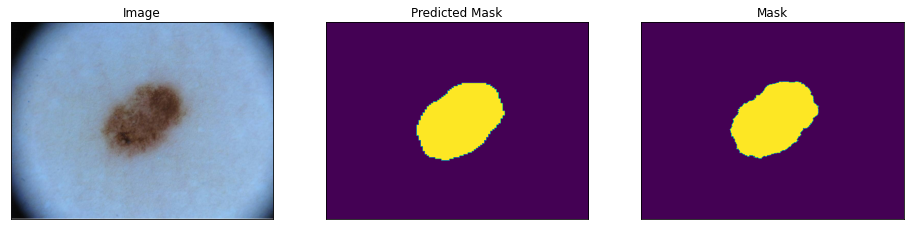

In [13]:
from utils.helper import Visualisation

Visualisation().plot_images(
    image=full_size_test_images[0].squeeze(),
    predicted_mask=full_size_predicted_masks[0],
    mask=full_size_test_masks[0].squeeze()
)

In [14]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=full_size_test_masks,
    predicted_masks=[mask * 255.0 for mask in full_size_predicted_masks], # predicted mask comes back normalized
    normalize=True
)

metrics

CPU times: user 56min 28s, sys: 44 s, total: 57min 12s
Wall time: 57min 52s


{'n_images': 300,
 'n_true_positives': 584797029,
 'n_true_positives_%': 0.8900059672098586,
 'n_true_negatives': 1908858696,
 'n_true_negatives_%': 0.9774889886880421,
 'n_false_positives': 43959922,
 'n_false_negatives': 72273879,
 'iou_score': 0.8139938600252825,
 'threshold_jaccard_index': 0.7575056215166552,
 'jaccard_similarity_index': 0.8139938600252825,
 'dice': 0.887141008169305,
 'f1_score': 0.4435705040846525,
 'sensitivity': 0.9065493840923559,
 'specificity': 0.9705057899571143,
 'accuracy': 0.9571384427298029}

### Experiment 11 - VGG, ImageNet Weights, 192x256

Experiments based on [experiment list](https://docs.google.com/spreadsheets/d/1bsp8puoiK3ay0rUYdjFXcbxXf6iSJZenIWtoiWczlBA/edit#gid=1999600204https://docs.google.com/spreadsheets/d/1bsp8puoiK3ay0rUYdjFXcbxXf6iSJZenIWtoiWczlBA/edit#gid=1999600204).

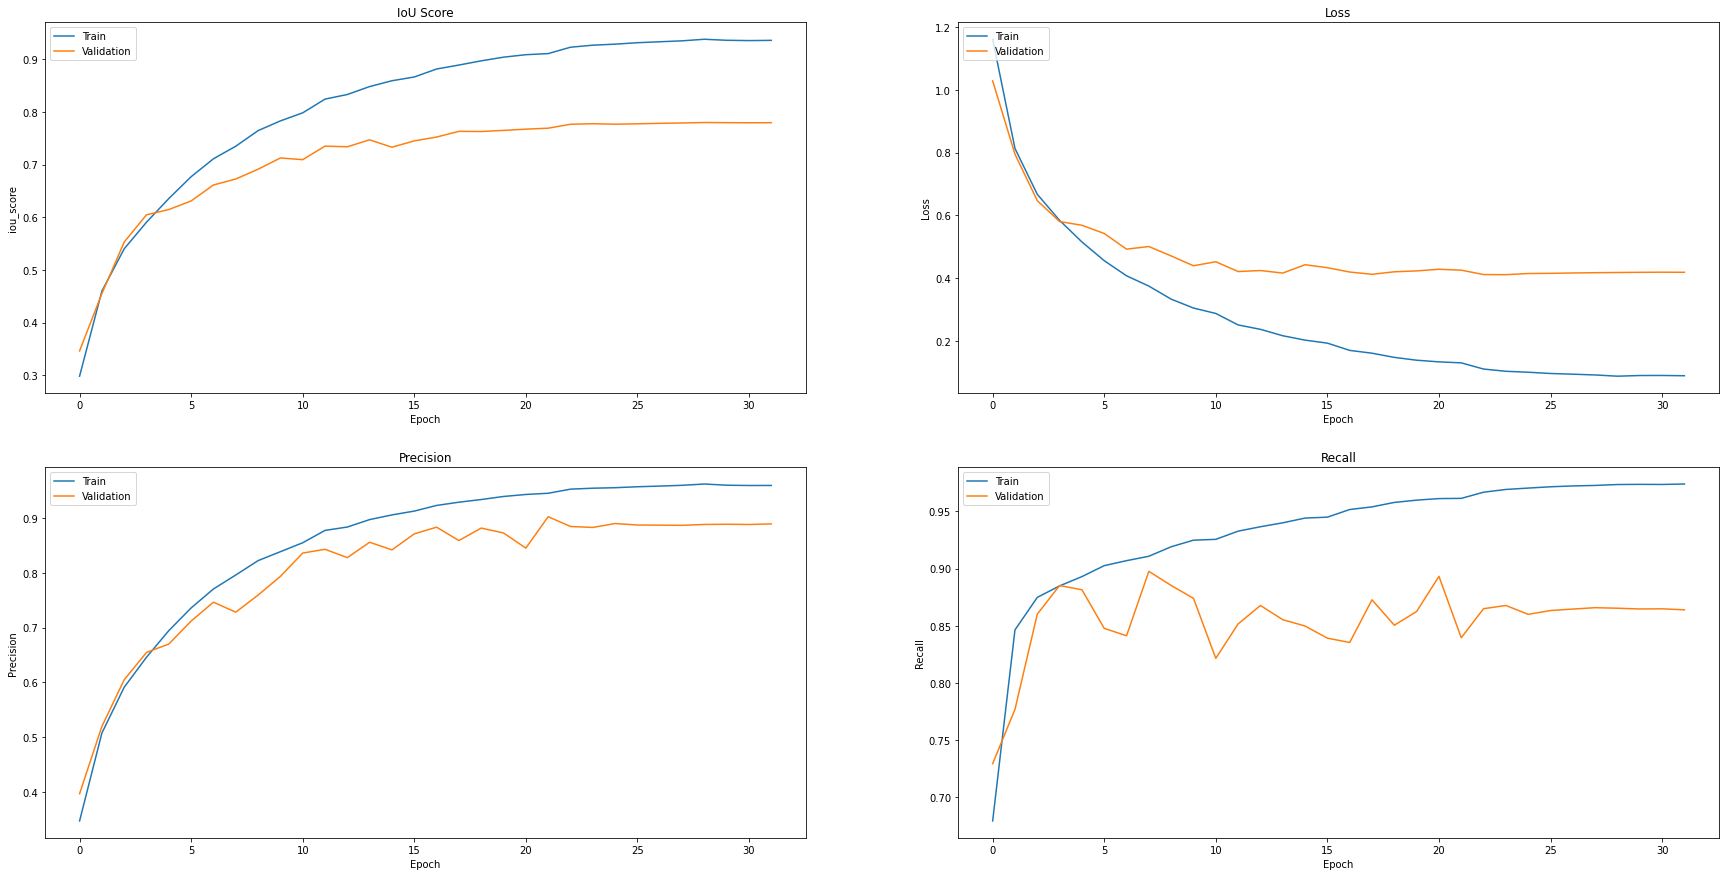

In [15]:
from utils.helper import Visualisation
import pickle
import os
from constants import EXPORT_DIR

AZURE_PATH = os.path.join(EXPORT_DIR, "azure", "2021_05_18_1529", "unet")

azure_hitory_path = os.path.join(AZURE_PATH, "unet_11_train_history.pkl")
azure_history = pickle.load(open(azure_hitory_path, "rb"))
Visualisation().plot_curves(azure_history)

#### Test Images (Unseen)

In [16]:
import segmentation_models as sm

azure_model = sm.Unet(encoder_weights='imagenet', activation='sigmoid')
azure_model.load_weights(os.path.join(AZURE_PATH, "unet_11_weights_only.h5"))

In [17]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(256, 192), size=5)

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


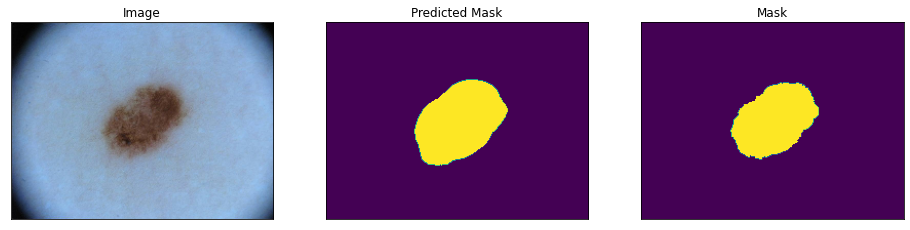

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


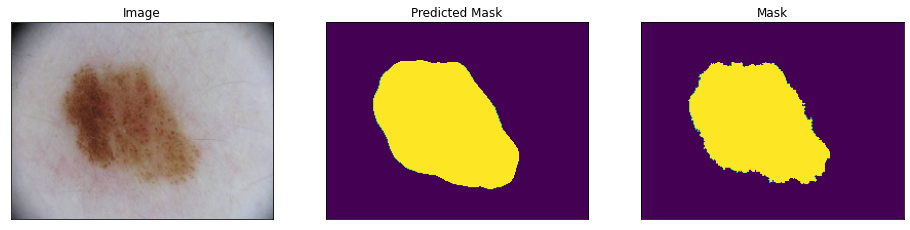

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


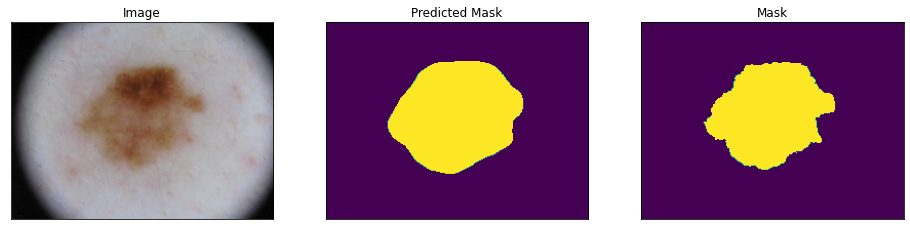

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


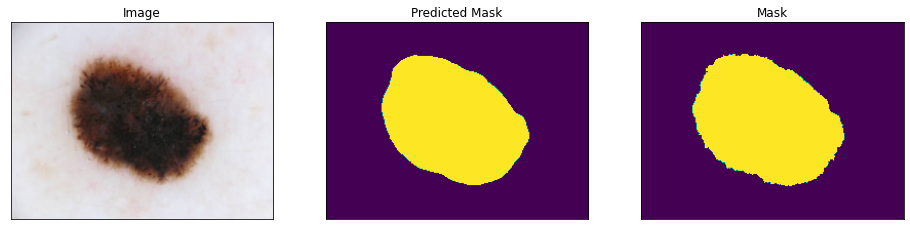

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


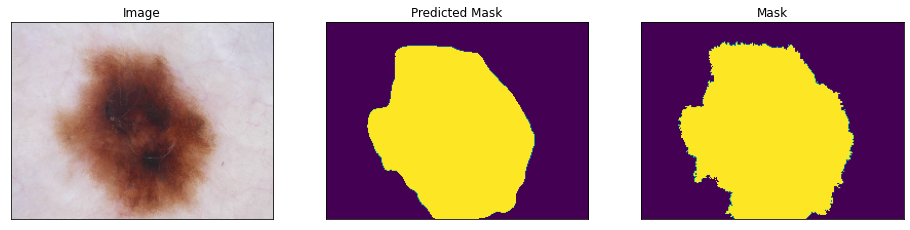

In [18]:
NotebookHelper().plot_images_masks(azure_model, test_images, test_masks)

### Calculate Metrics

This metric calculation is inspired on the [umetrics library](https://github.com/quantumjot/unet_segmentation_metrics).

The calculation uses the jaccard index threshold from the dataset description [landing page](https://challenge2018.isic-archive.com/task1/), section `metrics`, which is `0.65`.

In [19]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(256, 192))
print(len(test_images))

300


In [20]:
%%time

import numpy as np

predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    predicted_mask = azure_model.predict(test_image).round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

assert predicted_masks.shape == (len(test_masks), 192, 256, 1)

CPU times: user 5min 12s, sys: 26.9 s, total: 5min 39s
Wall time: 1min 7s


In [21]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

CPU times: user 42.1 s, sys: 221 ms, total: 42.3 s
Wall time: 42.7 s


{'n_images': 300,
 'n_true_positives': 3085416,
 'n_true_positives_%': 0.9049698584477739,
 'n_true_negatives': 11034827,
 'n_true_negatives_%': 0.973416105432982,
 'n_false_positives': 301360,
 'n_false_negatives': 323997,
 'iou_score': 0.8239736415349591,
 'threshold_jaccard_index': 0.7667946103697614,
 'jaccard_similarity_index': 0.8239736415349591,
 'dice': 0.8931774740193873,
 'f1_score': 0.44658873700969365,
 'sensitivity': 0.9215908567440476,
 'specificity': 0.9688335846086935,
 'accuracy': 0.9575902642144096}

#### Full Image Resolution Metrics

In [22]:
%%time

from constants import TEST_DIR
from utils.helper import NotebookHelper

full_size_test_images, full_size_test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, normalize=False)
print(len(full_size_test_images))

300
CPU times: user 2min, sys: 9.12 s, total: 2min 9s
Wall time: 2min 10s


In [23]:
%%time

import cv2
import numpy as np

full_size_predicted_masks = []

for index, full_size_test_image in enumerate(full_size_test_images):
        height, width = full_size_test_images[index].shape[:-1]
        # scale up predicted mask to original image resolution
        full_size_predicted_mask = cv2.resize(
            src=predicted_masks[index],
            dsize=(width, height),
            interpolation=cv2.INTER_NEAREST
        )
        full_size_predicted_mask = np.expand_dims(full_size_predicted_mask, axis=2)
        
        assert full_size_predicted_mask.shape[:-1] == full_size_test_image.shape[:-1], \
            "upscaled mask has not the same dimension as original image"
        
        full_size_predicted_masks.append(full_size_predicted_mask)

CPU times: user 7.55 s, sys: 16.6 s, total: 24.1 s
Wall time: 7.67 s


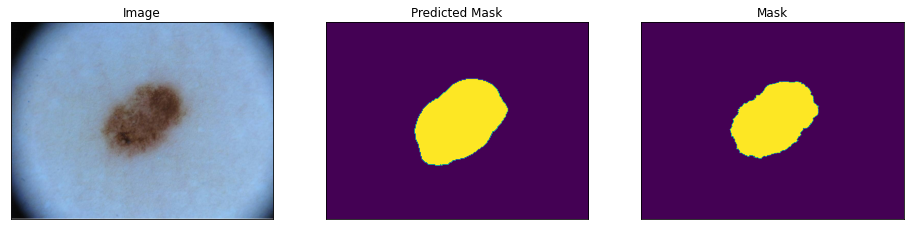

In [24]:
from utils.helper import Visualisation

Visualisation().plot_images(
    image=full_size_test_images[0].squeeze(),
    predicted_mask=full_size_predicted_masks[0],
    mask=full_size_test_masks[0].squeeze()
)

In [25]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=full_size_test_masks,
    predicted_masks=[mask * 255.0 for mask in full_size_predicted_masks], # predicted mask comes back normalized
    normalize=True
)

metrics

CPU times: user 55min 6s, sys: 36 s, total: 55min 42s
Wall time: 56min 8s


{'n_images': 300,
 'n_true_positives': 595770949,
 'n_true_positives_%': 0.9067072392740907,
 'n_true_negatives': 1903573552,
 'n_true_negatives_%': 0.9747825704107457,
 'n_false_positives': 49245066,
 'n_false_negatives': 61299959,
 'iou_score': 0.8204886591731495,
 'threshold_jaccard_index': 0.7613960733247606,
 'jaccard_similarity_index': 0.8204886591731495,
 'dice': 0.8911174425073551,
 'f1_score': 0.44555872125367757,
 'sensitivity': 0.9200261895939597,
 'specificity': 0.9684436058814356,
 'accuracy': 0.9571817266910799}

### Experiment 12 - VGG, ImageNet Weights, 192x256, Early Stopping Patience 3

Experiments based on [experiment list](https://docs.google.com/spreadsheets/d/1bsp8puoiK3ay0rUYdjFXcbxXf6iSJZenIWtoiWczlBA/edit#gid=1999600204https://docs.google.com/spreadsheets/d/1bsp8puoiK3ay0rUYdjFXcbxXf6iSJZenIWtoiWczlBA/edit#gid=1999600204).

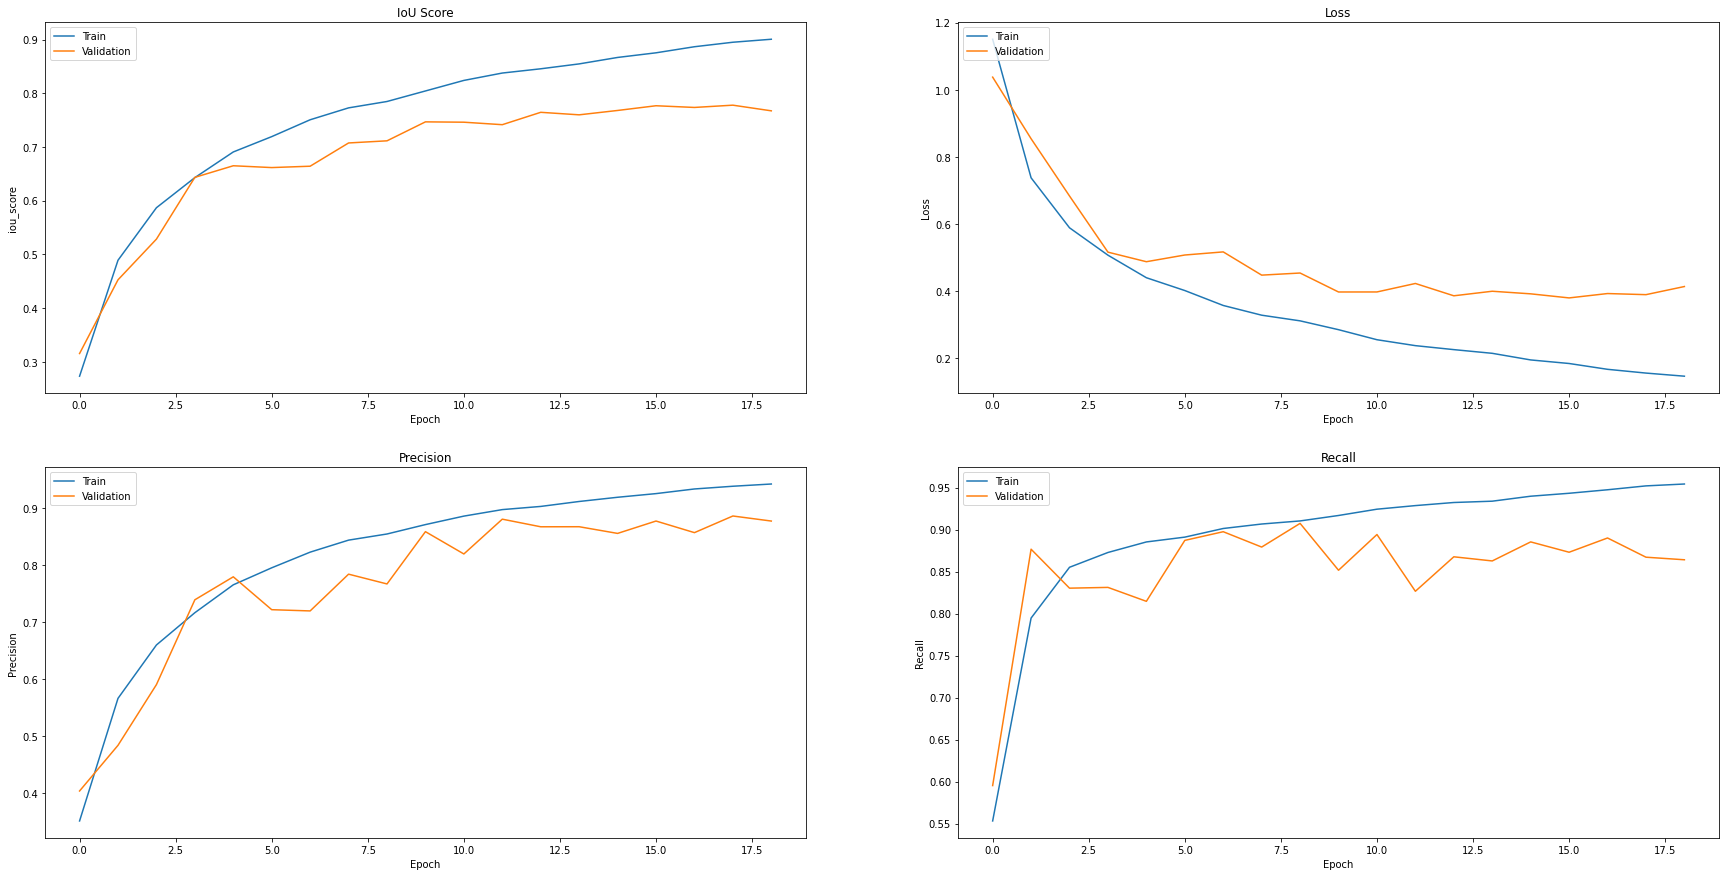

In [26]:
from utils.helper import Visualisation
import pickle
import os
from constants import EXPORT_DIR

AZURE_PATH = os.path.join(EXPORT_DIR, "azure", "2021_05_23_0040", "unet")

azure_hitory_path = os.path.join(AZURE_PATH, "unet_12_train_history.pkl")
azure_history = pickle.load(open(azure_hitory_path, "rb"))
Visualisation().plot_curves(azure_history)

#### Test Images (Unseen)

In [27]:
import segmentation_models as sm

azure_model = sm.Unet(encoder_weights='imagenet', activation='sigmoid')
azure_model.load_weights(os.path.join(AZURE_PATH, "unet_12_weights_only.h5"))

In [28]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(256, 192), size=5)

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


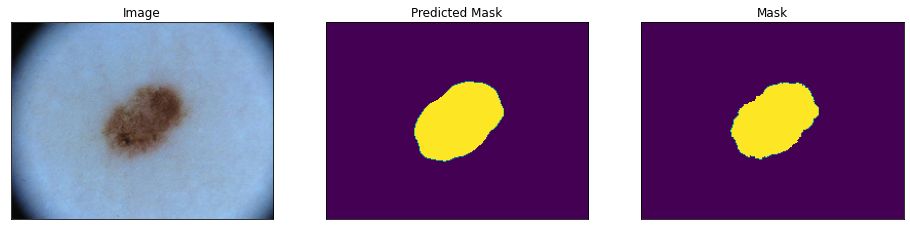

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


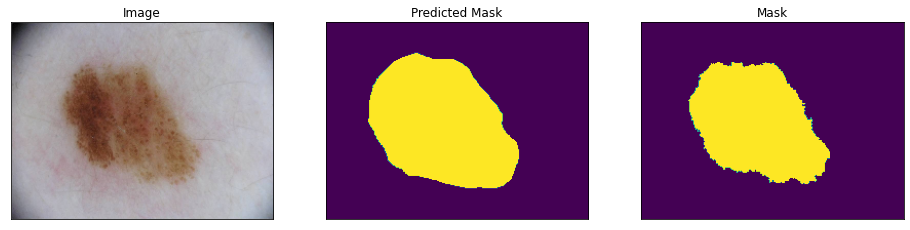

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


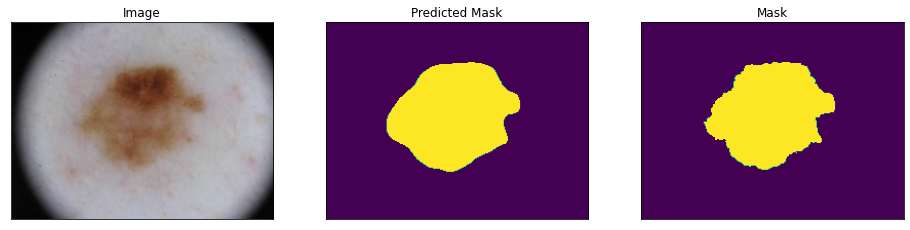

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


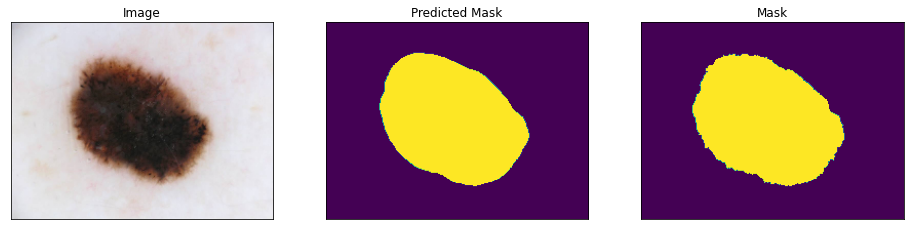

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


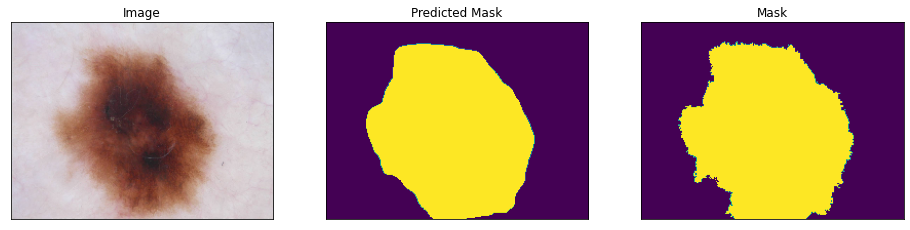

In [29]:
NotebookHelper().plot_images_masks(azure_model, test_images, test_masks)

### Calculate Metrics

This metric calculation is inspired on the [umetrics library](https://github.com/quantumjot/unet_segmentation_metrics).

The calculation uses the jaccard index threshold from the dataset description [landing page](https://challenge2018.isic-archive.com/task1/), section `metrics`, which is `0.65`.

In [30]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(256, 192))
print(len(test_images))

300


In [31]:
%%time

import numpy as np

predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    predicted_mask = azure_model.predict(test_image).round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

assert predicted_masks.shape == (len(test_masks), 192, 256, 1)

CPU times: user 5min 11s, sys: 26 s, total: 5min 37s
Wall time: 1min 2s


In [32]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

CPU times: user 39.8 s, sys: 111 ms, total: 40 s
Wall time: 40.1 s


{'n_images': 300,
 'n_true_positives': 3086436,
 'n_true_positives_%': 0.9052690301820284,
 'n_true_negatives': 11023919,
 'n_true_negatives_%': 0.9724538771281737,
 'n_false_positives': 312268,
 'n_false_negatives': 322977,
 'iou_score': 0.8186671808348286,
 'threshold_jaccard_index': 0.7551666249674276,
 'jaccard_similarity_index': 0.8186671808348286,
 'dice': 0.8902348083199045,
 'f1_score': 0.44511740415995227,
 'sensitivity': 0.9189991951163548,
 'specificity': 0.9669434672587298,
 'accuracy': 0.9569196912977429}

#### Full Image Resolution Metrics

In [33]:
%%time

from constants import TEST_DIR
from utils.helper import NotebookHelper

full_size_test_images, full_size_test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, normalize=False)
print(len(full_size_test_images))

300
CPU times: user 1min 59s, sys: 8.38 s, total: 2min 7s
Wall time: 2min 7s


In [34]:
%%time

import cv2
import numpy as np

full_size_predicted_masks = []

for index, full_size_test_image in enumerate(full_size_test_images):
        height, width = full_size_test_images[index].shape[:-1]
        # scale up predicted mask to original image resolution
        full_size_predicted_mask = cv2.resize(
            src=predicted_masks[index],
            dsize=(width, height),
            interpolation=cv2.INTER_NEAREST
        )
        full_size_predicted_mask = np.expand_dims(full_size_predicted_mask, axis=2)
        
        assert full_size_predicted_mask.shape[:-1] == full_size_test_image.shape[:-1], \
            "upscaled mask has not the same dimension as original image"
        
        full_size_predicted_masks.append(full_size_predicted_mask)

CPU times: user 7.45 s, sys: 17.4 s, total: 24.8 s
Wall time: 7.54 s


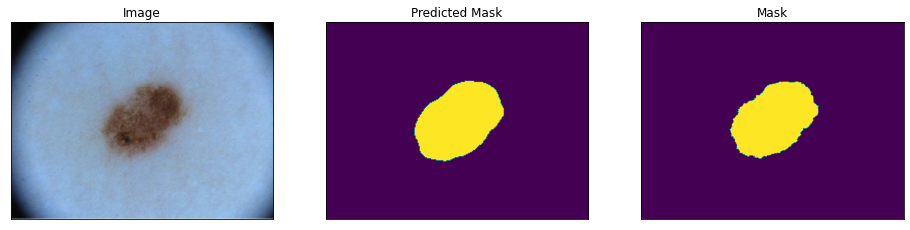

In [35]:
from utils.helper import Visualisation

Visualisation().plot_images(
    image=full_size_test_images[0].squeeze(),
    predicted_mask=full_size_predicted_masks[0],
    mask=full_size_test_masks[0].squeeze()
)

In [36]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=full_size_test_masks,
    predicted_masks=[mask * 255.0 for mask in full_size_predicted_masks], # predicted mask comes back normalized
    normalize=True
)

metrics

CPU times: user 55min 47s, sys: 39.7 s, total: 56min 27s
Wall time: 56min 55s


{'n_images': 300,
 'n_true_positives': 591850635,
 'n_true_positives_%': 0.9007408908141767,
 'n_true_negatives': 1901225772,
 'n_true_negatives_%': 0.9735803184563862,
 'n_false_positives': 51592846,
 'n_false_negatives': 65220273,
 'iou_score': 0.8179458640157204,
 'threshold_jaccard_index': 0.7566919276056633,
 'jaccard_similarity_index': 0.8179458640157204,
 'dice': 0.889777742158873,
 'f1_score': 0.4448888710794365,
 'sensitivity': 0.9190494709658455,
 'specificity': 0.9669780168031985,
 'accuracy': 0.9570111636923664}

### Experiment 13 - VGG, ImageNet Weights, 192x256

Experiments based on [experiment list](https://docs.google.com/spreadsheets/d/1bsp8puoiK3ay0rUYdjFXcbxXf6iSJZenIWtoiWczlBA/edit#gid=1999600204https://docs.google.com/spreadsheets/d/1bsp8puoiK3ay0rUYdjFXcbxXf6iSJZenIWtoiWczlBA/edit#gid=1999600204).

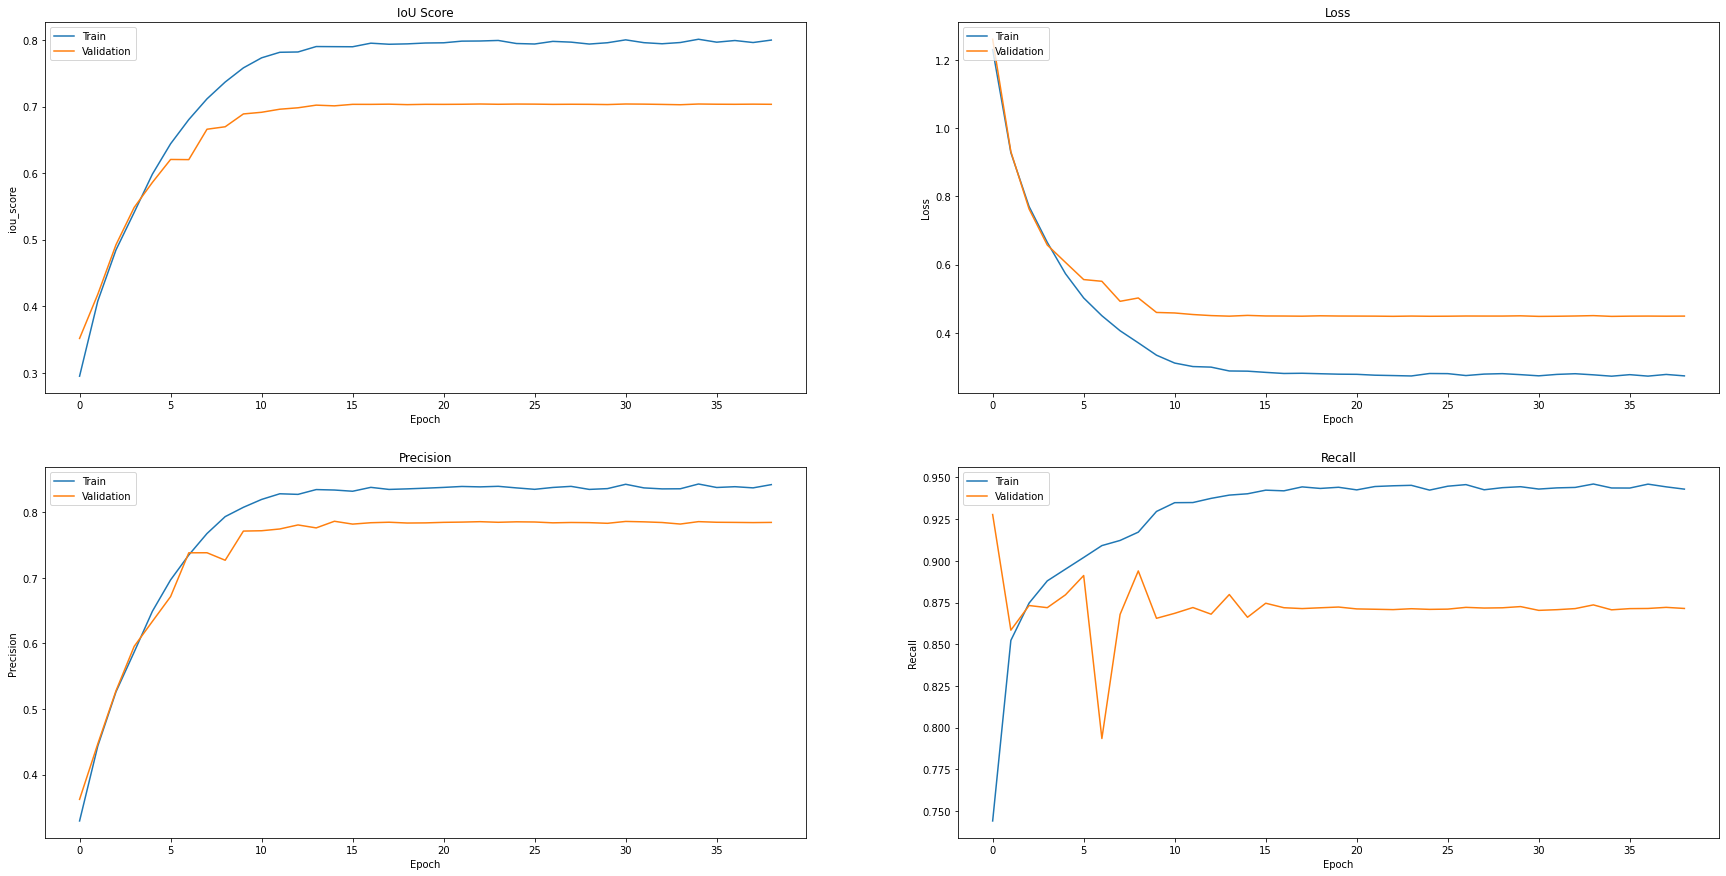

In [37]:
from utils.helper import Visualisation
import pickle
import os
from constants import EXPORT_DIR

AZURE_PATH = os.path.join(EXPORT_DIR, "azure", "2021_05_23_0211")

azure_hitory_path = os.path.join(AZURE_PATH, "unet_13_train_history.pkl")
azure_history = pickle.load(open(azure_hitory_path, "rb"))
Visualisation().plot_curves(azure_history)

#### Test Images (Unseen)

In [38]:
import segmentation_models as sm

azure_model = sm.Unet(encoder_weights='imagenet', activation='sigmoid')
azure_model.load_weights(os.path.join(AZURE_PATH, "unet_13_weights_only.h5"))

In [39]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(256, 192), size=5)

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


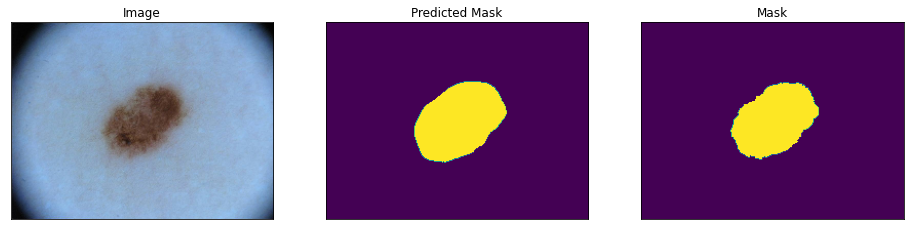

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


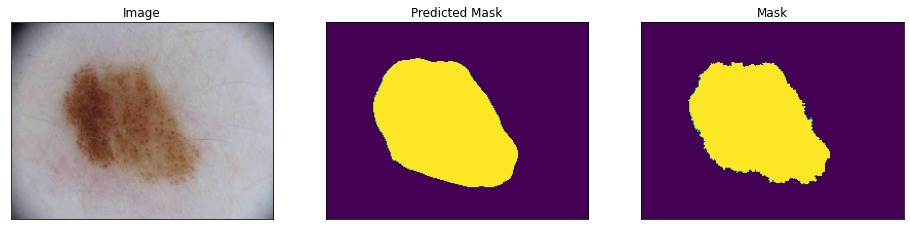

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


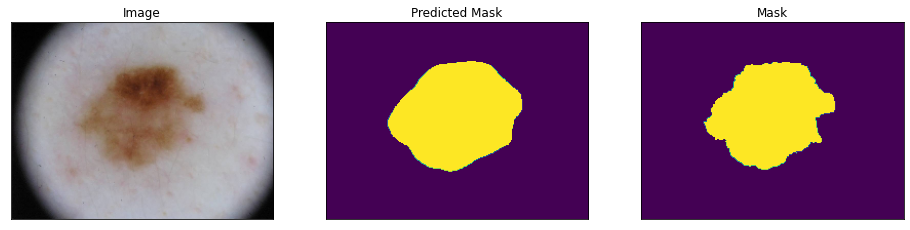

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


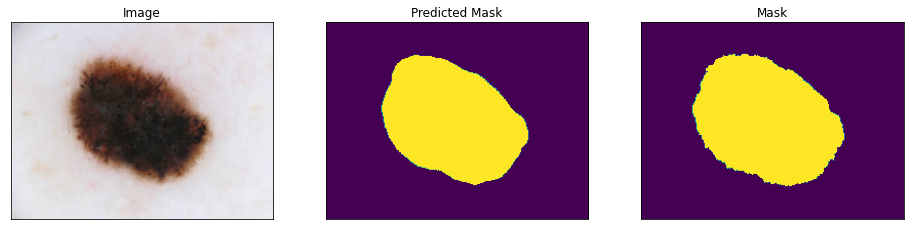

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


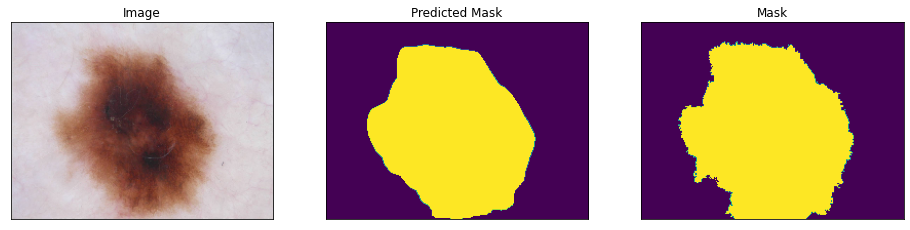

In [40]:
NotebookHelper().plot_images_masks(azure_model, test_images, test_masks)

### Calculate Metrics

This metric calculation is inspired on the [umetrics library](https://github.com/quantumjot/unet_segmentation_metrics).

The calculation uses the jaccard index threshold from the dataset description [landing page](https://challenge2018.isic-archive.com/task1/), section `metrics`, which is `0.65`.

In [41]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(256, 192))
print(len(test_images))

300


In [42]:
%%time

import numpy as np

predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    predicted_mask = azure_model.predict(test_image).round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

assert predicted_masks.shape == (len(test_masks), 192, 256, 1)

CPU times: user 5min 12s, sys: 27.4 s, total: 5min 39s
Wall time: 1min 6s


In [43]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

CPU times: user 42.5 s, sys: 408 ms, total: 42.9 s
Wall time: 43.5 s


{'n_images': 300,
 'n_true_positives': 3089998,
 'n_true_positives_%': 0.9063137848069448,
 'n_true_negatives': 11013614,
 'n_true_negatives_%': 0.9715448413121626,
 'n_false_positives': 322573,
 'n_false_negatives': 319415,
 'iou_score': 0.816098970739848,
 'threshold_jaccard_index': 0.7527073962360117,
 'jaccard_similarity_index': 0.816098970739848,
 'dice': 0.8881846449281845,
 'f1_score': 0.44409232246409225,
 'sensitivity': 0.9220732954362135,
 'specificity': 0.9660136047524697,
 'accuracy': 0.95646240234375}

#### Full Image Resolution Metrics

In [44]:
%%time

from constants import TEST_DIR
from utils.helper import NotebookHelper

full_size_test_images, full_size_test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, normalize=False)
print(len(full_size_test_images))

300
CPU times: user 2min, sys: 9.34 s, total: 2min 9s
Wall time: 2min 8s


In [45]:
%%time

import cv2
import numpy as np

full_size_predicted_masks = []

for index, full_size_test_image in enumerate(full_size_test_images):
        height, width = full_size_test_images[index].shape[:-1]
        # scale up predicted mask to original image resolution
        full_size_predicted_mask = cv2.resize(
            src=predicted_masks[index],
            dsize=(width, height),
            interpolation=cv2.INTER_NEAREST
        )
        full_size_predicted_mask = np.expand_dims(full_size_predicted_mask, axis=2)
        
        assert full_size_predicted_mask.shape[:-1] == full_size_test_image.shape[:-1], \
            "upscaled mask has not the same dimension as original image"
        
        full_size_predicted_masks.append(full_size_predicted_mask)

CPU times: user 7.23 s, sys: 16.5 s, total: 23.7 s
Wall time: 7.46 s


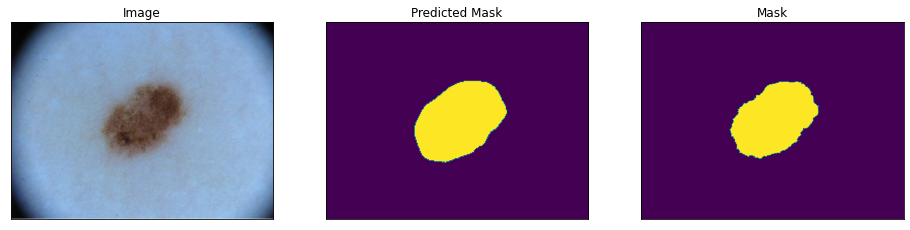

In [46]:
from utils.helper import Visualisation

Visualisation().plot_images(
    image=full_size_test_images[0].squeeze(),
    predicted_mask=full_size_predicted_masks[0],
    mask=full_size_test_masks[0].squeeze()
)

In [47]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=full_size_test_masks,
    predicted_masks=[mask * 255.0 for mask in full_size_predicted_masks], # predicted mask comes back normalized
    normalize=True
)

metrics

CPU times: user 55min 26s, sys: 38 s, total: 56min 4s
Wall time: 56min 29s


{'n_images': 300,
 'n_true_positives': 592845646,
 'n_true_positives_%': 0.9022552037869253,
 'n_true_negatives': 1898028081,
 'n_true_negatives_%': 0.9719428437976926,
 'n_false_positives': 54790537,
 'n_false_negatives': 64225262,
 'iou_score': 0.8120735652182641,
 'threshold_jaccard_index': 0.7487978244261352,
 'jaccard_similarity_index': 0.8120735652182641,
 'dice': 0.8858265796318491,
 'f1_score': 0.44291328981592454,
 'sensitivity': 0.9202079632170012,
 'specificity': 0.9655248192141823,
 'accuracy': 0.9560135300100219}

### Experiment 14 - VGG, ImageNet Weights, 192x256, Jaccard Loss only

Experiments based on [experiment list](https://docs.google.com/spreadsheets/d/1bsp8puoiK3ay0rUYdjFXcbxXf6iSJZenIWtoiWczlBA/edit#gid=1999600204https://docs.google.com/spreadsheets/d/1bsp8puoiK3ay0rUYdjFXcbxXf6iSJZenIWtoiWczlBA/edit#gid=1999600204).

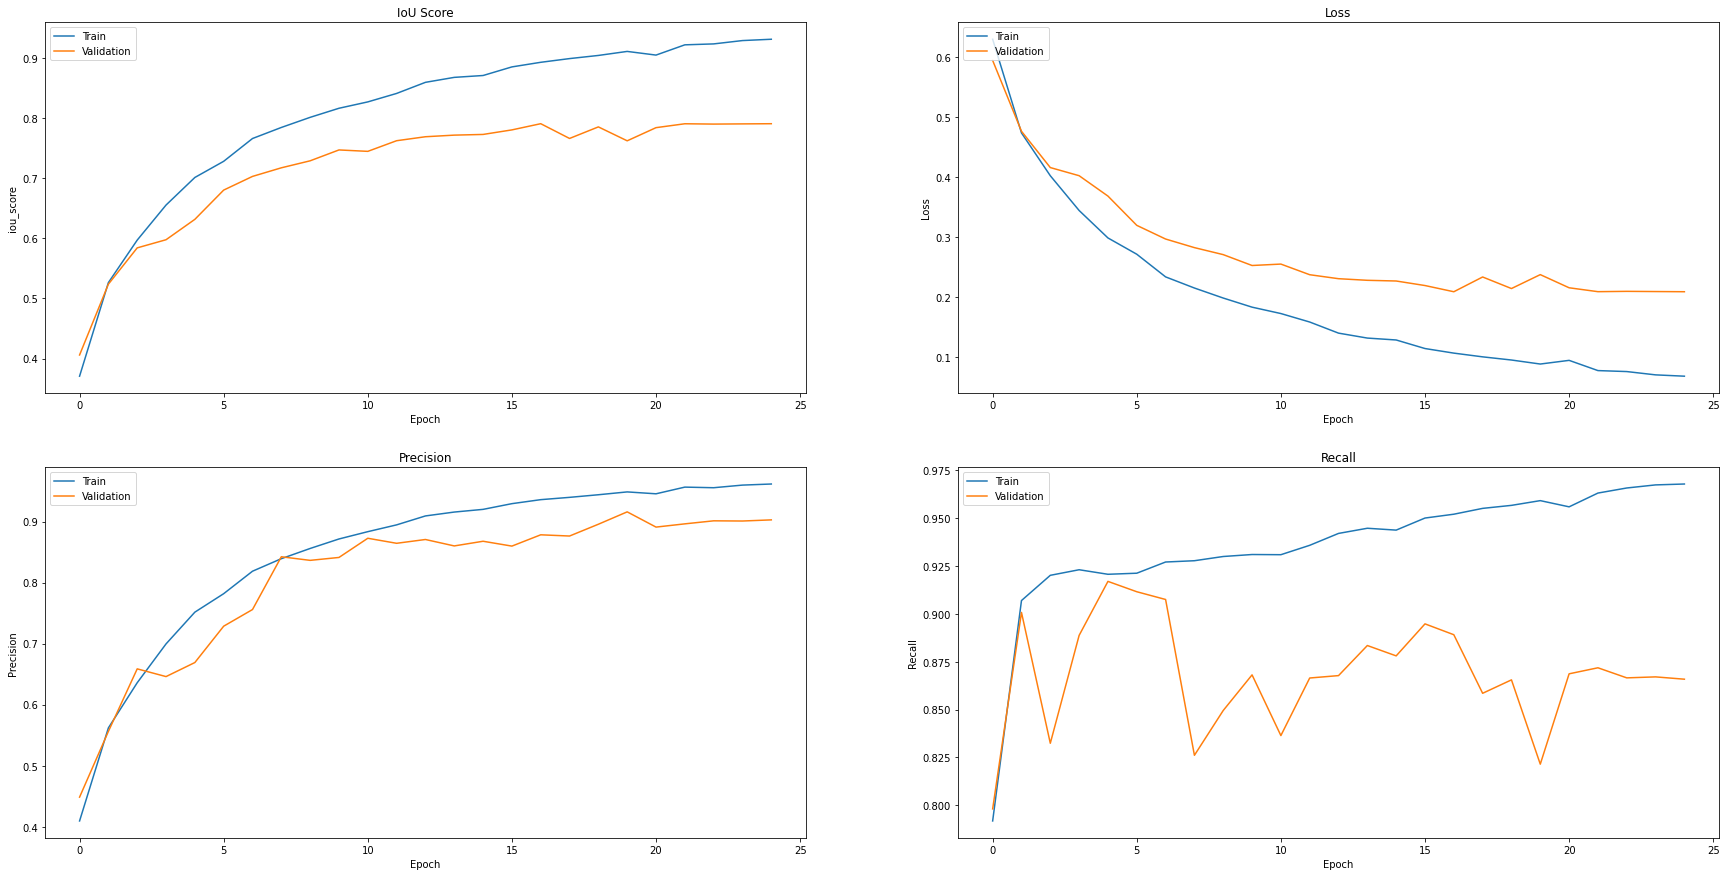

In [48]:
from utils.helper import Visualisation
import pickle
import os
from constants import EXPORT_DIR

AZURE_PATH = os.path.join(EXPORT_DIR, "azure", "2021_05_23_1352")

azure_hitory_path = os.path.join(AZURE_PATH, "unet_14_train_history.pkl")
azure_history = pickle.load(open(azure_hitory_path, "rb"))
Visualisation().plot_curves(azure_history)

#### Test Images (Unseen)

In [49]:
import segmentation_models as sm

azure_model = sm.Unet(encoder_weights='imagenet', activation='sigmoid')
azure_model.load_weights(os.path.join(AZURE_PATH, "unet_14_weights_only.h5"))

In [50]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(256, 192), size=5)

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


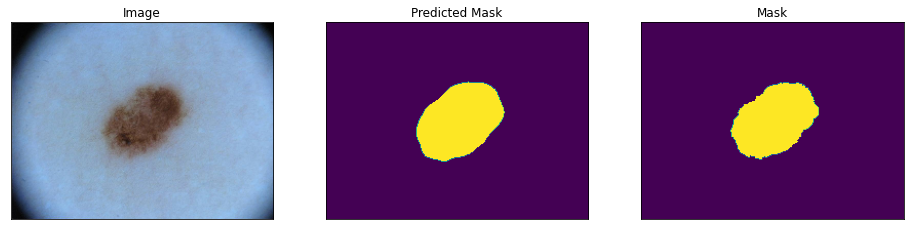

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


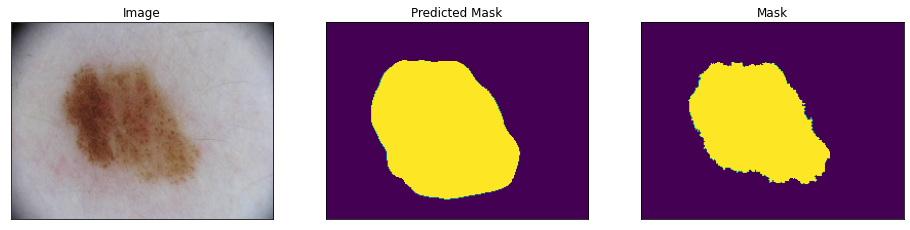

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


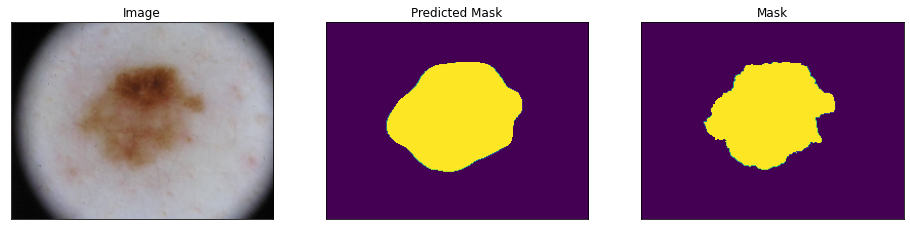

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


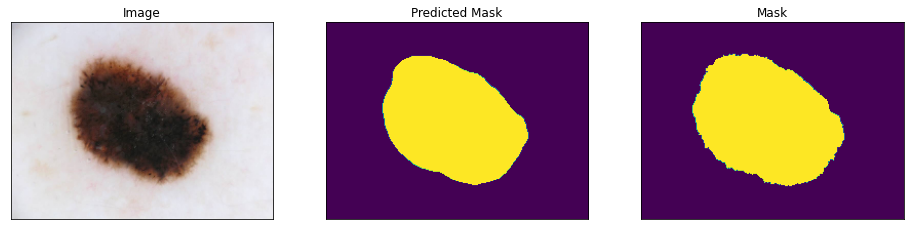

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


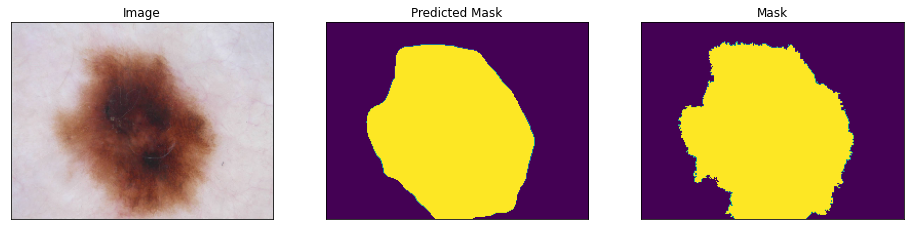

In [51]:
NotebookHelper().plot_images_masks(azure_model, test_images, test_masks)

### Calculate Metrics

This metric calculation is inspired on the [umetrics library](https://github.com/quantumjot/unet_segmentation_metrics).

The calculation uses the jaccard index threshold from the dataset description [landing page](https://challenge2018.isic-archive.com/task1/), section `metrics`, which is `0.65`.

In [52]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(256, 192))
print(len(test_images))

300


In [53]:
%%time

import numpy as np

predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    predicted_mask = azure_model.predict(test_image).round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

assert predicted_masks.shape == (len(test_masks), 192, 256, 1)

CPU times: user 5min 10s, sys: 26.3 s, total: 5min 36s
Wall time: 1min 3s


In [54]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

CPU times: user 42.1 s, sys: 261 ms, total: 42.4 s
Wall time: 43 s


{'n_images': 300,
 'n_true_positives': 3119748,
 'n_true_positives_%': 0.9150396270560357,
 'n_true_negatives': 11001403,
 'n_true_negatives_%': 0.9704676713607494,
 'n_false_positives': 334784,
 'n_false_negatives': 289665,
 'iou_score': 0.8212589580249683,
 'threshold_jaccard_index': 0.7701395236738963,
 'jaccard_similarity_index': 0.8212589580249683,
 'dice': 0.8917598594059359,
 'f1_score': 0.44587992970296797,
 'sensitivity': 0.9268188740543515,
 'specificity': 0.9633601968884272,
 'accuracy': 0.9576518419053821}

#### Full Image Resolution Metrics

In [55]:
%%time

from constants import TEST_DIR
from utils.helper import NotebookHelper

full_size_test_images, full_size_test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, normalize=False)
print(len(full_size_test_images))

300
CPU times: user 1min 59s, sys: 8.86 s, total: 2min 7s
Wall time: 2min 7s


In [56]:
%%time

import cv2
import numpy as np

full_size_predicted_masks = []

for index, full_size_test_image in enumerate(full_size_test_images):
        height, width = full_size_test_images[index].shape[:-1]
        # scale up predicted mask to original image resolution
        full_size_predicted_mask = cv2.resize(
            src=predicted_masks[index],
            dsize=(width, height),
            interpolation=cv2.INTER_NEAREST
        )
        full_size_predicted_mask = np.expand_dims(full_size_predicted_mask, axis=2)
        
        assert full_size_predicted_mask.shape[:-1] == full_size_test_image.shape[:-1], \
            "upscaled mask has not the same dimension as original image"
        
        full_size_predicted_masks.append(full_size_predicted_mask)

CPU times: user 7.13 s, sys: 16.8 s, total: 23.9 s
Wall time: 7.23 s


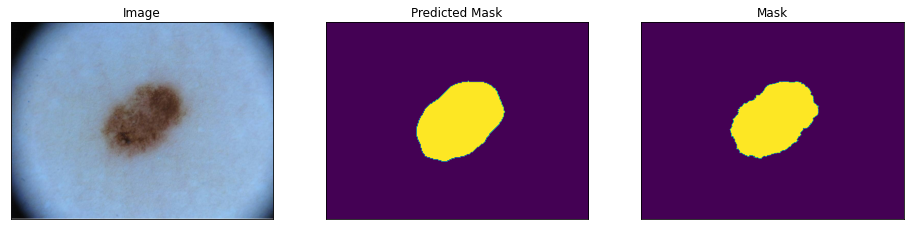

In [57]:
from utils.helper import Visualisation

Visualisation().plot_images(
    image=full_size_test_images[0].squeeze(),
    predicted_mask=full_size_predicted_masks[0],
    mask=full_size_test_masks[0].squeeze()
)

In [58]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=full_size_test_masks,
    predicted_masks=[mask * 255.0 for mask in full_size_predicted_masks], # predicted mask comes back normalized
    normalize=True
)

metrics

CPU times: user 55min 22s, sys: 38.1 s, total: 56min 1s
Wall time: 56min 23s


{'n_images': 300,
 'n_true_positives': 603027644,
 'n_true_positives_%': 0.9177512451974209,
 'n_true_negatives': 1894198955,
 'n_true_negatives_%': 0.9699820236965807,
 'n_false_positives': 58619663,
 'n_false_negatives': 54043264,
 'iou_score': 0.8178812934795319,
 'threshold_jaccard_index': 0.7603699960961732,
 'jaccard_similarity_index': 0.8178812934795319,
 'dice': 0.8897861586792669,
 'f1_score': 0.44489307933963346,
 'sensitivity': 0.9253471279212931,
 'specificity': 0.9628698945145114,
 'accuracy': 0.9572397891814637}

### Experiment 16 - VGG, ImageNet Weights, 192x256, Batch Size 4

Experiments based on [experiment list](https://docs.google.com/spreadsheets/d/1bsp8puoiK3ay0rUYdjFXcbxXf6iSJZenIWtoiWczlBA/edit#gid=1999600204https://docs.google.com/spreadsheets/d/1bsp8puoiK3ay0rUYdjFXcbxXf6iSJZenIWtoiWczlBA/edit#gid=1999600204).

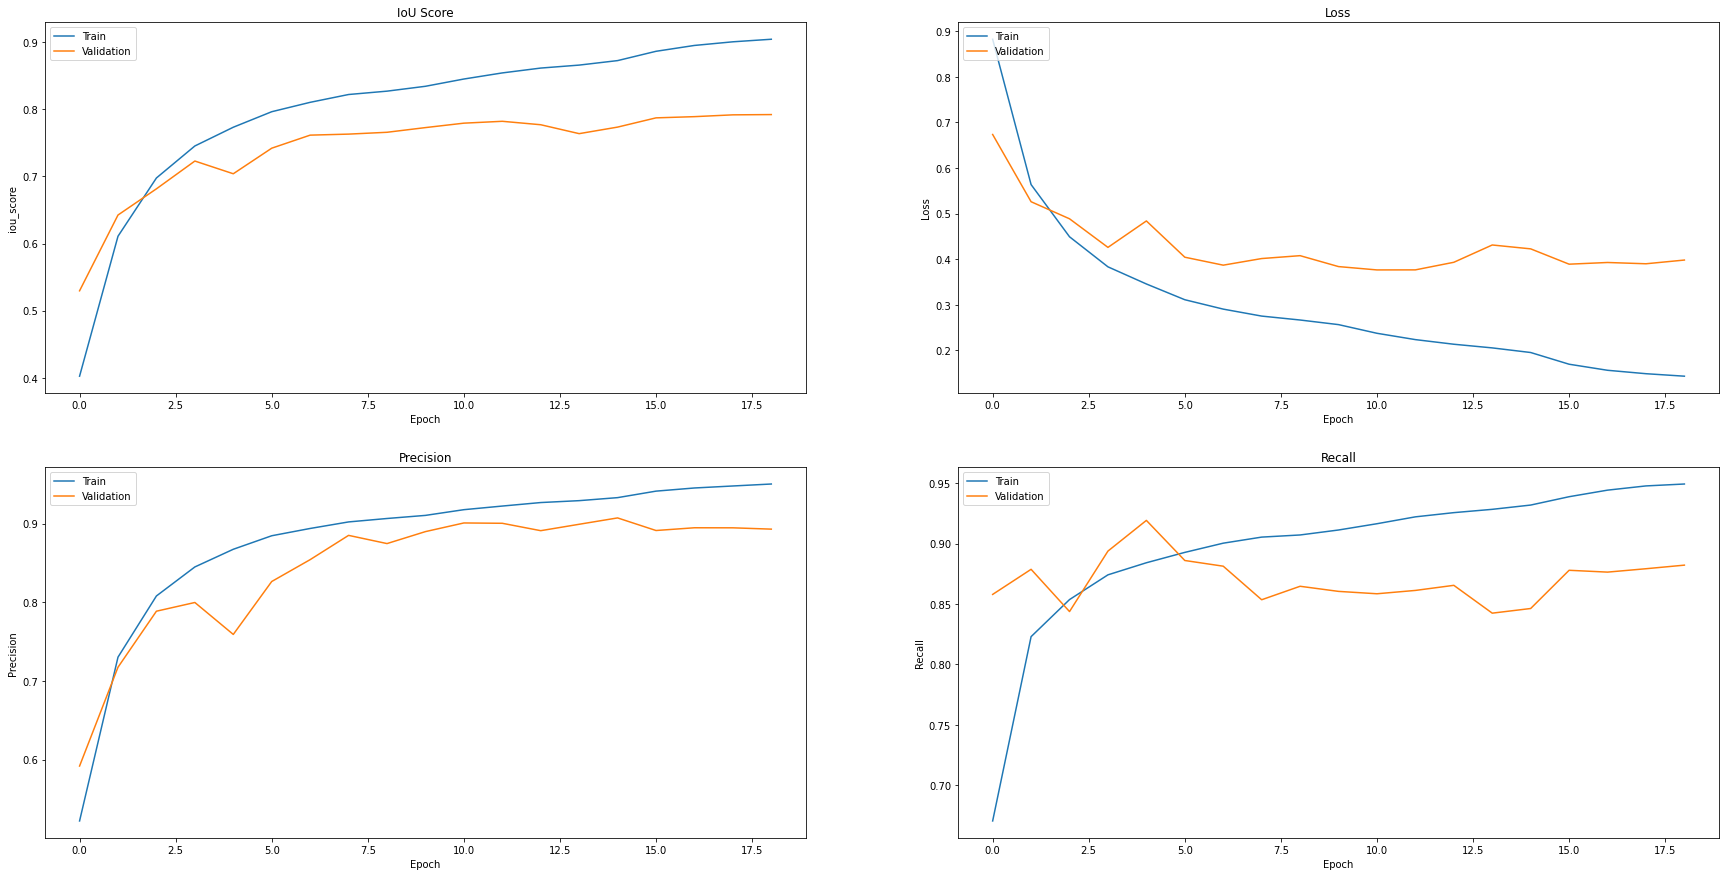

In [70]:
from utils.helper import Visualisation
import pickle
import os
from constants import EXPORT_DIR

AZURE_PATH = os.path.join(EXPORT_DIR, "azure", "2021_05_26_2133")

azure_hitory_path = os.path.join(AZURE_PATH, "unet_16_train_history.pkl")
azure_history = pickle.load(open(azure_hitory_path, "rb"))
Visualisation().plot_curves(azure_history)

#### Test Images (Unseen)

In [71]:
import segmentation_models as sm

azure_model = sm.Unet(encoder_weights='imagenet', activation='sigmoid')
azure_model.load_weights(os.path.join(AZURE_PATH, "unet_16_weights_only.h5"))

In [72]:
%%time

from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(256, 192), size=5)

CPU times: user 117 ms, sys: 20.7 ms, total: 137 ms
Wall time: 146 ms


Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


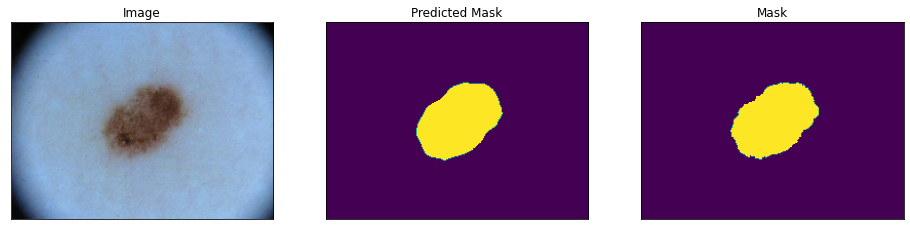

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


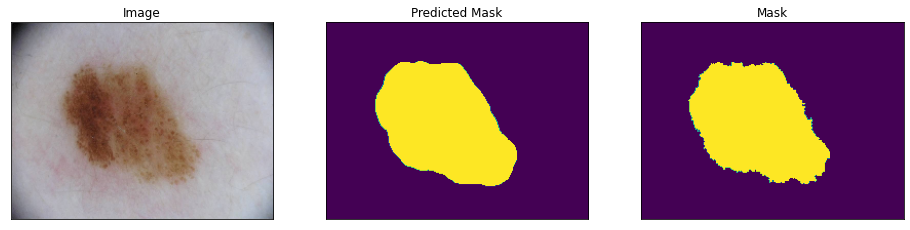

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


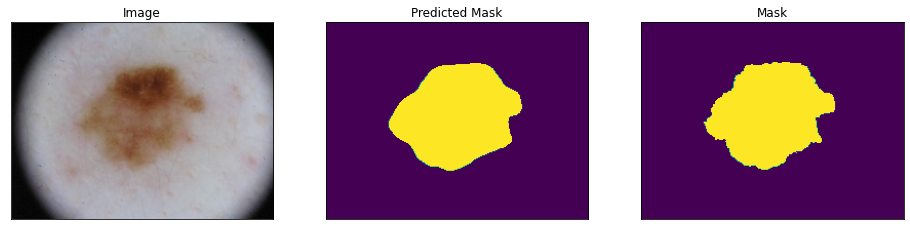

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


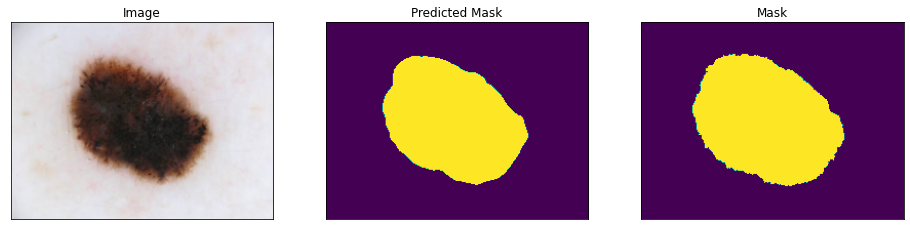

Image shape: (1, 192, 256, 3)
Predicted mask shape: (1, 192, 256, 1)
Mask shape: (192, 256, 1)


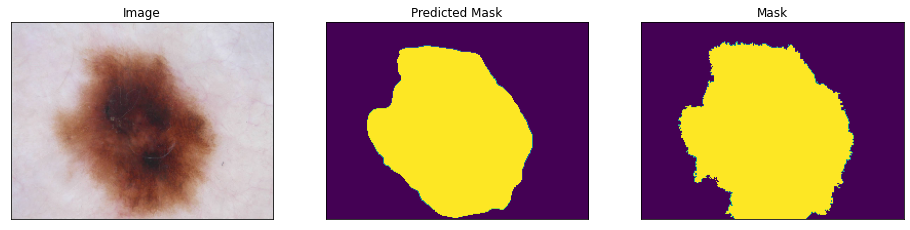

In [73]:
NotebookHelper().plot_images_masks(azure_model, test_images, test_masks)

### Calculate Metrics

This metric calculation is based on the [umetrics library](https://github.com/quantumjot/unet_segmentation_metrics).

The calculation uses the jaccard index threshold from the dataset description [landing page](https://challenge2018.isic-archive.com/task1/), section `metrics`, which is `0.65`.

In [74]:
%%time

from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(256, 192))
print(len(test_images))

300
CPU times: user 1min 19s, sys: 4.28 s, total: 1min 24s
Wall time: 1min 25s


In [75]:
%%time

import numpy as np

predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    predicted_mask = azure_model.predict(test_image).round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

assert predicted_masks.shape == (len(test_masks), 192, 256, 1)

CPU times: user 5min 12s, sys: 27.4 s, total: 5min 39s
Wall time: 1min 4s


In [76]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

CPU times: user 41.5 s, sys: 178 ms, total: 41.6 s
Wall time: 41.9 s


{'n_images': 300,
 'n_true_positives': 3011848,
 'n_true_positives_%': 0.8833919504618537,
 'n_true_negatives': 11099761,
 'n_true_negatives_%': 0.9791441337373845,
 'n_false_positives': 236426,
 'n_false_negatives': 397565,
 'iou_score': 0.8168756748433125,
 'threshold_jaccard_index': 0.7421297744276649,
 'jaccard_similarity_index': 0.8168756748433125,
 'dice': 0.8883733488521064,
 'f1_score': 0.4441866744260532,
 'sensitivity': 0.8880379241598465,
 'specificity': 0.9738984267426183,
 'accuracy': 0.9570047336154512}

#### Full Image Resolution Metrics

In [77]:
%%time

from constants import TEST_DIR
from utils.helper import NotebookHelper

full_size_test_images, full_size_test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, normalize=False)
print(len(full_size_test_images))

300
CPU times: user 2min, sys: 9.77 s, total: 2min 10s
Wall time: 2min 10s


In [78]:
%%time

import cv2
import numpy as np

full_size_predicted_masks = []

for index, full_size_test_image in enumerate(full_size_test_images):
        height, width = full_size_test_images[index].shape[:-1]
        # scale up predicted mask to original image resolution
        full_size_predicted_mask = cv2.resize(
            src=predicted_masks[index],
            dsize=(width, height),
            interpolation=cv2.INTER_NEAREST
        )
        full_size_predicted_mask = np.expand_dims(full_size_predicted_mask, axis=2)
        
        assert full_size_predicted_mask.shape[:-1] == full_size_test_image.shape[:-1], \
            "upscaled mask has not the same dimension as original image"
        
        full_size_predicted_masks.append(full_size_predicted_mask)

CPU times: user 7.41 s, sys: 17.6 s, total: 25 s
Wall time: 7.44 s


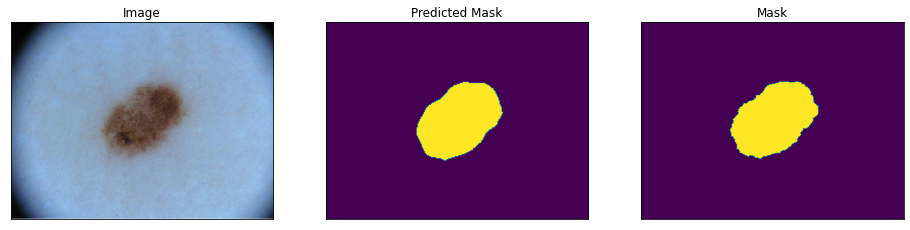

In [79]:
from utils.helper import Visualisation

Visualisation().plot_images(
    image=full_size_test_images[0].squeeze(),
    predicted_mask=full_size_predicted_masks[0],
    mask=full_size_test_masks[0].squeeze()
)

In [80]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=full_size_test_masks,
    predicted_masks=[mask * 255.0 for mask in full_size_predicted_masks], # predicted mask comes back normalized
    normalize=True
)

metrics

CPU times: user 55min 22s, sys: 39.3 s, total: 56min 1s
Wall time: 56min 31s


{'n_images': 300,
 'n_true_positives': 584622416,
 'n_true_positives_%': 0.889740222679285,
 'n_true_negatives': 1912728812,
 'n_true_negatives_%': 0.9794707989618316,
 'n_false_positives': 40089806,
 'n_false_negatives': 72448492,
 'iou_score': 0.814515279472485,
 'threshold_jaccard_index': 0.7377378211186923,
 'jaccard_similarity_index': 0.814515279472485,
 'dice': 0.8869574451908394,
 'f1_score': 0.4434787225954197,
 'sensitivity': 0.8871232605016911,
 'specificity': 0.9735434799486313,
 'accuracy': 0.9566430646402477}